# Kaggle - Predict Future Sales Competition - Modeling
In this notebook, we train various models to predict the sales price.

## Setup & Imports

In [1]:
import os
import dask
import time
import joblib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse
from dask.delayed import delayed
from dask.distributed import Client
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.linear_model import LinearRegression, SGDRegressor

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43637 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.24 GB


# Load Data 
Load the data we prepared in the previous notebook

In [3]:
all_sales_features = sparse.load_npz("build/train_sales_features.npz")
test_sales_features = sparse.load_npz("build/test_sales_features.npz")
all_sales_months = np.load("build/sales_month.npz")["train"]
test_sales_months = np.load("build/sales_month.npz")["test"]

In [4]:
print(f"no. of train/valid data: {all_sales_features.shape[0]}")
print(f"no. of test data: {test_sales_features.shape[0]}")

no. of train/valid data: 2741567
no. of test data: 5000


Split the training data into train and validation subsets

In [5]:
all_idxs = np.arange(len(all_sales_months))
train_idxs, valid_idxs = train_test_split(all_idxs,
                                          test_size=5000)


train_sales_features = all_sales_features[train_idxs]
valid_sales_features = all_sales_features[valid_idxs]
train_sales_months = all_sales_months[train_idxs]
valid_sales_months = all_sales_months[valid_idxs]

Setup split for validation data

In [6]:
# setup split for validation data
valid_fold = np.full(all_idxs.shape, -1)
valid_fold[valid_idxs] = 0
valid_split = PredefinedSplit(valid_fold)

# Train Model
## Model Selection
Inital modeling: train a selection of models to choose one to optimise:
- Linear: SGDRegressor
- Decision Tree: XGBoost

> These models where choosen due to the large data size


Since we are training a regression model, our optimisation ob

In [7]:
all_idxs.shape

(2741567,)

In [8]:
%%time

models = [
    # linear model
    XGBRegressor(n_jobs=-1),
    SGDRegressor()
]

# trains model and returns cross validation results
def train_model(model):
    print("training... ", model.__class__.__name__)
    return cross_validate(model,
                          all_sales_features,
                          all_sales_months,
                          scoring=make_scorer(
                              mean_squared_error,
                              greater_is_better=False
                          ),
                          return_train_score=True,
                          return_estimator=True,
                          cv=valid_split)

results = [  train_model(model) for model in models ]

training...  XGBRegressor
[16:36:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
training...  SGDRegressor
CPU times: user 24min 49s, sys: 7.91 s, total: 24min 57s
Wall time: 5min 3s


In [9]:
print(f"XGBRegressor valid mse: {results[0]['test_score']}")
print(f"SGDRegressor valid mse: {results[1]['test_score']}")

XGBRegressor valid mse: [-240.05124769]
SGDRegressor valid mse: [-870.98038474]


## Hyperparameter Tuning 
### Evaluate Model
Evaluate model's performance using learning curve:

CPU times: user 26.5 s, sys: 5.96 s, total: 32.5 s
Wall time: 9min 15s


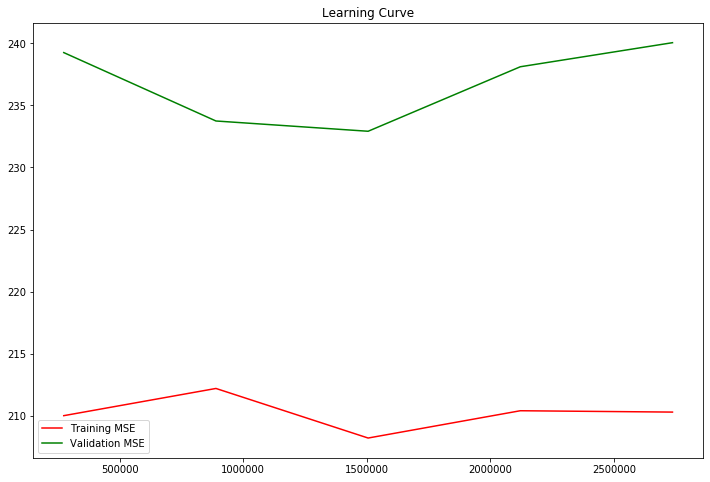

In [10]:
%%time
def plot_learning_curve(model):
    # evaluate model at different dataset sizes to collect data for learning curve
    train_sizes, train_mses, valid_mses = learning_curve(
        XGBRegressor(n_jobs=-1),
        all_sales_features,
        all_sales_months,
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
        cv=valid_split,
        n_jobs=-1)
    # plot learning
    plt.figure(figsize=(12, 8))
    plt.title("Learning Curve")
    plt.plot(train_sizes, -train_mses, "r-", label="Training MSE")
    plt.plot(train_sizes, -valid_mses, "g-", label="Validation MSE")
    plt.legend()
    
plot_learning_curve(XGBRegressor(n_jobs=-1))

Based on the learning curve above, we can infer that the model is overfitting.
Methods to combat overfitting with `xgboost`
- Reducing the number of estimators `n_estimators`
- Reducing the max depth of trees trained `max_depth`
- Increasing the `gamma`/`min_split_loss` to add regularisation
- Increasing `subsample` to ensure that each tree only sees a sample of the dataset

### Tune Hyperparameters
Tune Hyperparameters with `hyperopt`:
- define objective function `train_evaluate_model()` for `hyperopt`:

In [11]:
# evaluate train model, returning metrics 
# returns mse, mae, r2
def evaluate_model(model, inputs, actuals):
    predicts = model.predict(inputs)
    return (
        mean_squared_error(actuals, predicts),
        mean_absolute_error(actuals, predicts),
        r2_score(actuals, predicts)
    )

# train and evaluate based on the given parameters:
def train_evaluate_model(params):
    # train model with selected hyperparameters
    print(params)
    begin_time = time.time()
    model = XGBRegressor(n_jobs=-1, **params)
    model.fit(train_sales_features, train_sales_months)
    train_secs = time.time() - begin_time 

    # evaluate trained model
    train_mse, train_mae, train_r2 = evaluate_model(model, 
                                                    train_sales_features,
                                                    train_sales_months)
    
    valid_mse, valid_mae, valid_r2 = evaluate_model(model, 
                                                    valid_sales_features,
                                                    valid_sales_months)
    eval_secs = time.time() - (begin_time + train_secs)
    
    return {
        "loss": train_mse,
        "status": STATUS_OK,
        "true_loss": valid_mse,
        "metrics": {
            "train_mse": train_mse,
            "valid_mse": valid_mse, 
            "train_mae": train_mae,
            "valid_mae": valid_mae, 
            "train_r2": train_r2,
            "valid_r2": valid_r2,
        },
        "timings": {
            "train_secs": train_secs,
            "eval_secs": eval_secs,
        }
    }

- define parameter space for hyperparamter tuning

In [12]:
param_space = {
    "lr": hp.loguniform("learning_rate", -4, 1),
    "max_depth": 2 + hp.randint("max_depth", 8),
    "n_est": 40 + hp.randint("n_estimators", 125),
    "min_split_loss": hp.loguniform("min_split_loss", -4, 2),
    "subsample": hp.uniform("subsample", 0.4, 1.0)
}

- perform hyper parameter search with `hyperopt`'s `TPE`:

In [13]:
trials = Trials()
best_params = fmin(train_evaluate_model,
                   space=param_space,
                   algo=tpe.suggest,
                   max_evals=8,
                   trials=trials)

{'lr': 0.33334297588607714, 'max_depth': 2, 'min_split_loss': 0.040378168234139936, 'n_est': 109, 'subsample': 0.9609977235767413}
[16:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'lr': 0.021702913848904954, 'max_depth': 8, 'min_split_loss': 0.0971916970082859, 'n_est': 78, 'subsample': 0.653003657137108}
[16:52:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'lr': 0.02391136605801696, 'max_depth': 3, 'min_split_loss': 0.09441261620166472, 'n_est': 164, 'subsample': 0.7017728511829803}
[17:01:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'lr': 1.551613901995598, 'max_depth': 9, 'min_split_loss': 0.03398800151660092, 'n_est': 157, 'subsample': 0.5483384612002199}
[17:05:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in fa